In [1]:
import pandas as pd
import warnings
from src.utility import *
warnings.filterwarnings('ignore')

# %matplotlib widget 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# notebook works with jupyter notebook and widget works better with jupyter lab. In case of
# problem with implementation look at the link https://github.com/matplotlib/ipympl

In [2]:
print(plt.style.available)
plt.style.use('fivethirtyeight')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Load Dataset

In [3]:
path_cohort = '~/UMCUtrecht/KaplanMeier/DESAsurvival.pickle'
path_antibody = '~/UMCUtrecht/20211104_mismatch_ep_db.pickle'
df_abs = pd.read_pickle(path_antibody)
df_cohort = pd.read_pickle(path_cohort)
df = df_abs.merge(df_cohort, on='TransplantID')
print(df.columns)
cols = [
    'TransplantID', 'DESA_Status', 'EpvsHLA_Donor', '#DESA', 'DESA', 'RecipientAge_NOTR', 
    'DonorAge_NOTR', 'TypeOfDonor_NOTR', 'FailureCode10Y_R', 'GraftSurvival10Y_R', 'IL2rMoAb'
]
df = df[cols]
df

Index(['TransplantID', 'Epitope_Mismatch', 'DESA_Status', 'EpvsHLA_Donor',
       '#DESA', 'DESA', 'RecipientAge_NOTR', 'RecipientSex_NOTR',
       'DonorAge_NOTR', 'DonorSex_NOTR', 'Retransplant', 'TxYear', 'Center',
       'TypeOfDonor_NOTR', 'LivingDonorNum', 'GraftFunction_NOTR',
       'ColdIschaemicPeriod_NOTR', 'CIPHour', 'CIPHour_DBD', 'CIPHour_DCD',
       'CurrentPRA_NOTR', 'HighPRA_NOTR', 'IL2rMoAb', 'GraftSurvival10y',
       'GraftSurvival10Y_R', 'GraftSurvival1y', 'GraftSurvivalY1_R',
       'FailureCode10y', 'FailureCode10Y_R', 'FailureCode1Y_R',
       'FailureCode1y', 'RejectionCodeY10_R', 'PatientSurvival10Y',
       'PatientDeathCode10Y', 'GraftSurvival3m', 'FailureCode3m'],
      dtype='object')


,TransplantID,DESA_Status,EpvsHLA_Donor,#DESA,DESA,RecipientAge_NOTR,DonorAge_NOTR,TypeOfDonor_NOTR,FailureCode10Y_R,GraftSurvival10Y_R,IL2rMoAb
0,4036,No DESA,{},0,{},54,44,Deceased,0,10.000000,1
1,2809,No DESA,{},0,{},32,54,Deceased,0,10.000000,1
2,862,No DESA,{},0,{},27,44,Deceased,1,6.956164,1
3,3549,No DESA,{},0,{},40,23,Deceased,0,4.509589,0
4,12,No DESA,{},0,{},38,55,Deceased,1,0.010959,1
...,...,...,...,...,...,...,...,...,...,...,...
4685,994,No MFI,{},0,{},43,51,Deceased,0,10.000000,0
4686,995,No DESA,{},0,{},37,54,Deceased,0,10.000000,0
4687,996,No MFI,{},0,{},46,21,Deceased,0,10.000000,0
4688,997,No MFI,{},0,{},23,42,Deceased,0,10.000000,0


# Finding relevant DESA using Diff plots

In the above figure epitopes that demonstrate a value larger than +10% and lower than -10% are clinically relevant. The ones above

Let we denote the set of all epitopes by  $\mathcal{E}$. From this set, we choose a specific epitope $ e \in \mathcal E$, and sketch the Kaplan-Meier curve for all the Tx with DESA that contain that specific epitope, denoted by $\mathcal{KM}_{e}$ [Red Curve]. On the other hand, we sketch the Kaplan-Meier curve for all the other Tx with DESA, denoted by $\mathcal{KM}_{\mathcal{E}-e}$ [Blue Curve]. Given the Kaplan-Meier curves $\mathcal{KM}_{e}$ and $\mathcal{KM}_{\mathcal{E}-e} $, we define the set of relevant epitopes, denoted by  $\mathcal R , as follow

$$ \mathcal R := \{ e \in \mathcal E :\ \lvert \mathcal{KM}_{\mathcal E -e} (t) -\mathcal{KM}_{e}(t) \rvert > \alpha \} $$

where  $ \alpha$ is a threshold, $t \in [0, T]$  is the time window of the analysis, i.e. $T=10$. In words, relevant epitopes are defined such that the difference between Kaplan-Meier curves including the epitope and the curves excluding the epitopes is larger than the threshold $\alpha$. The analysis is carried out for the time window $[0, 10]$ with the highly frequent epitopes. 

$ \mathcal R $:  Set of relevant DESA

$ \mathcal E $:  Set of all epitopes

$ e $: Specific Epitope

$ \alpha$ : Threshold, i.e. 10%

$ \mathcal{KM} $: Kaplan-Meier curve



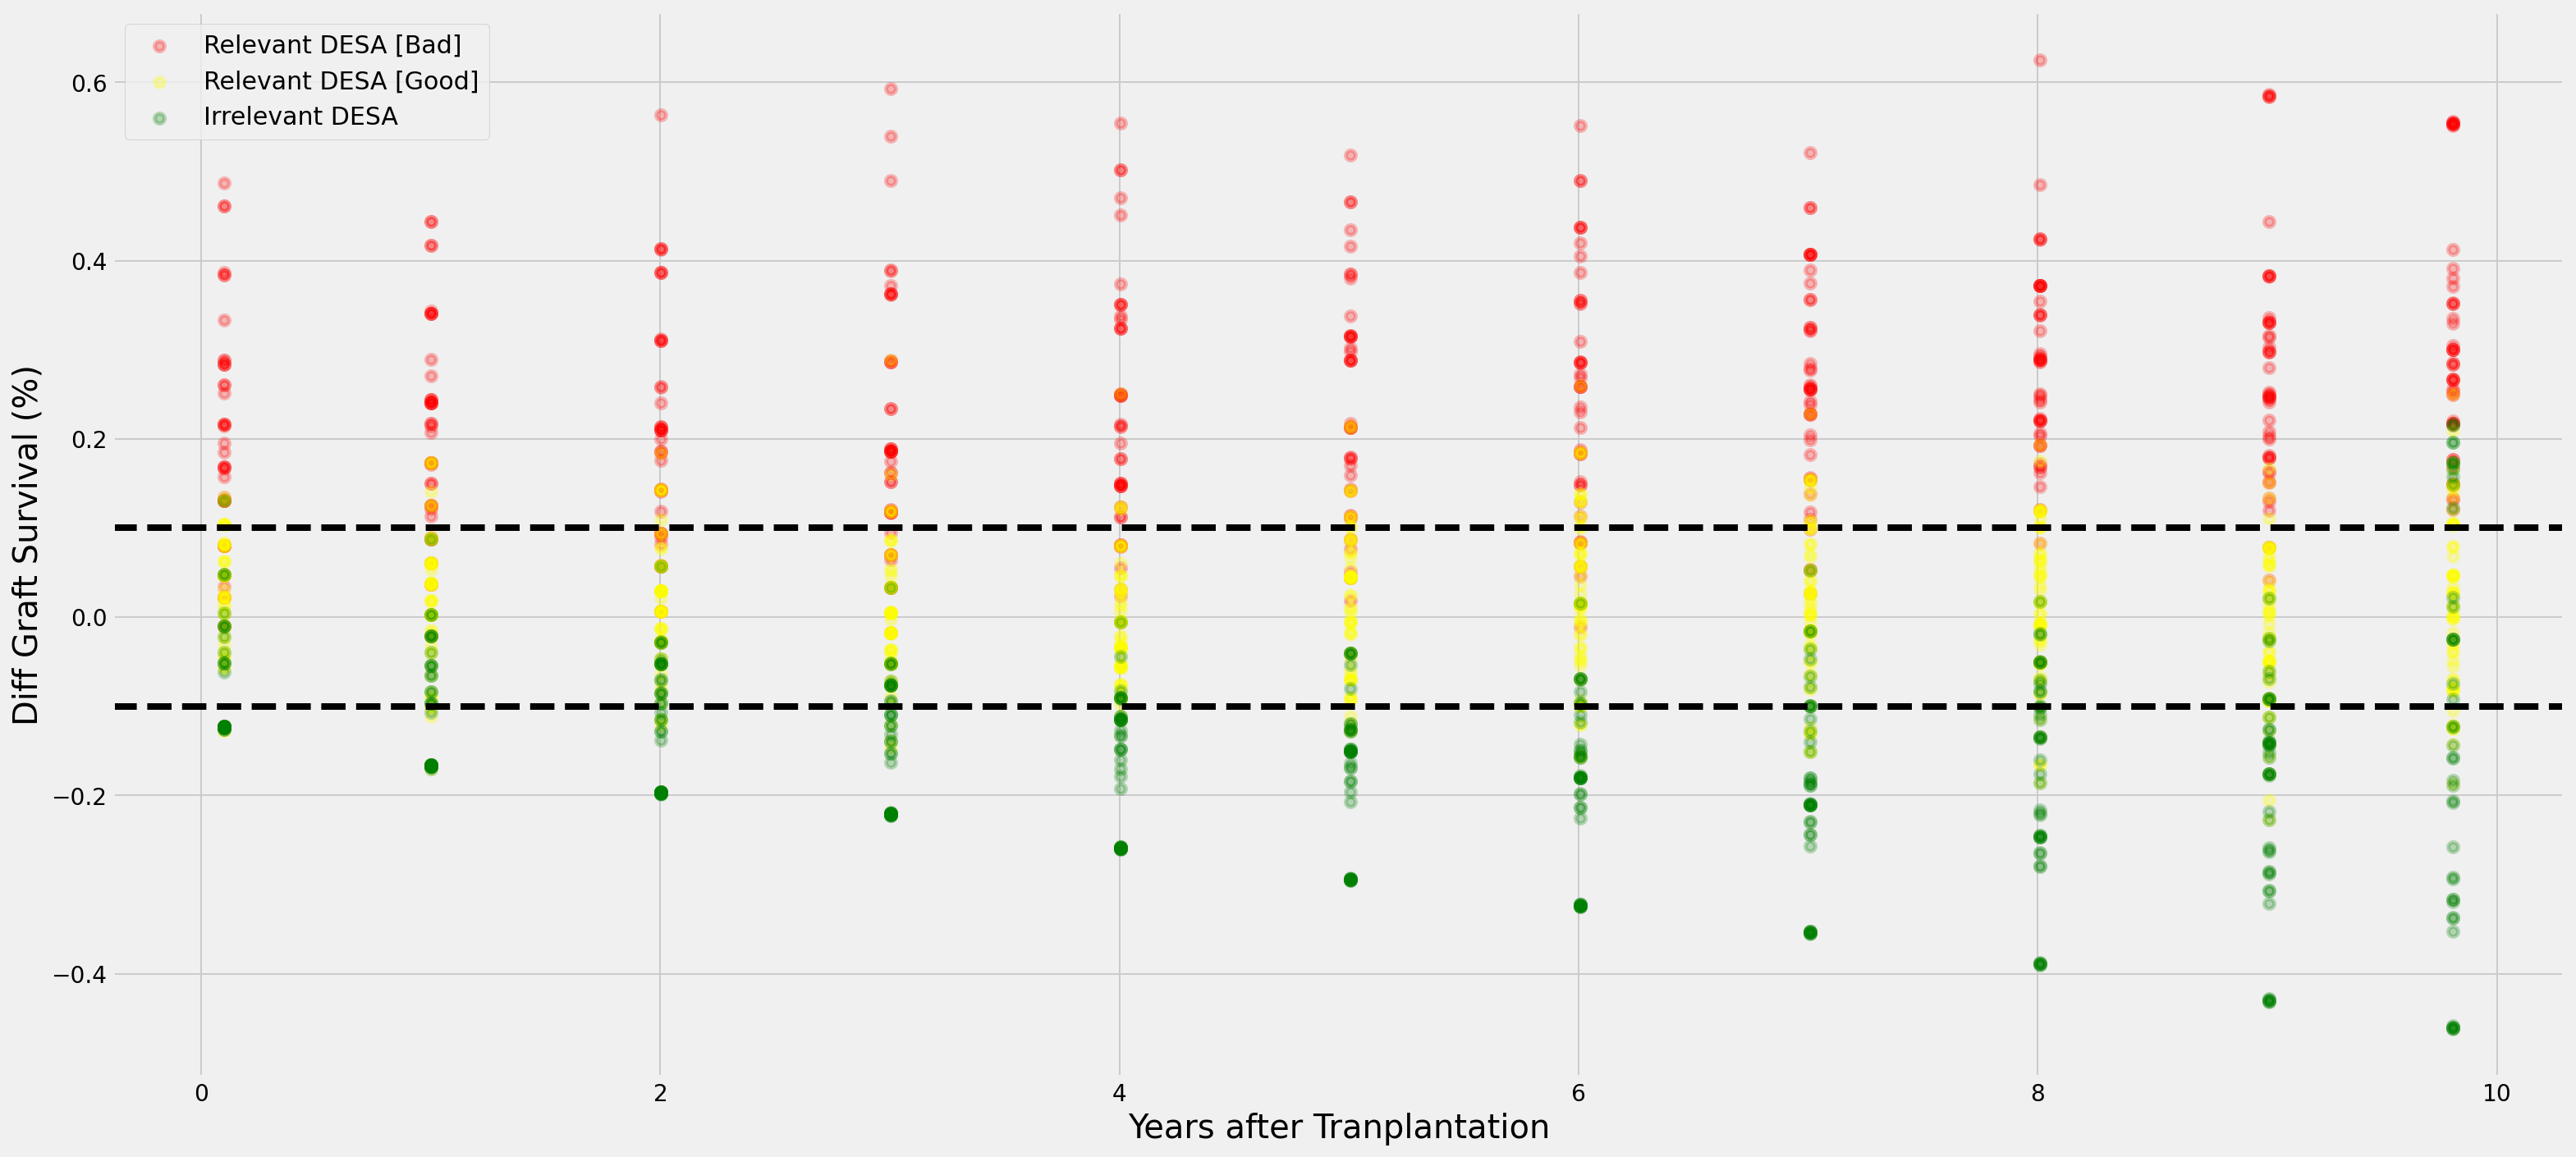

In [4]:
from lifelines.plotting import plot_lifetimes
class_I_A = {
    '150AAH', '56R', '62EE', '62QE', '66NH', '76VDT',
    '105S', '73ID', '207S', '245AS', '193AV', '150AH'
            }

class_I_B = {
    '44RMA', '45KE', '62GRN',  '71TD',  '76ED', '80TLR',
    '74Y', '65QIA', '94I', '97V', '158T', '144QL', 
            }
class_II_dq = {'45EV', '96HK', '76ED'}
class_II_drb1 = {'31FY', '37S', '74L', '96HK', '142M'}
class_II_dr134 = {'4Q', '31FH', '32H', '149H'}
class_II_dr5 = {
    '96EV', '108T', '30D', '71A', '70DA', 
    '67F', '30G[DR]', '70DRA', '74A', '6C', 
               }

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

relevant_desa = class_I | class_II_dr | class_II_dq 

irrelevant_ordered = {'26L[DR]', '28D', '30C', '31I', '37F', '37FL', '37YV[DQ]', '44RT','55PPA' , '57V[DR]', '57V[DQ]', '62LQ', '70QRA', '70QT', '70QA', '71ATD', 
                      '71QS', '73AN', '73G', '73TVS',  '73GQ', '80I', '97S', '97N', '98KN', '104AK', '116I', '120N','125SQ', '125G', '130Q', '147L', '151AHA', 
                      '152A', '152RA', '152RR', '163RW', '173K', '177DT', '180E', '193PL',  '245V', '267QE'}

band_irrelevant = {'65GK', '163LG', '152HA', '107W', '163R', '95V', '57DE', '96Q', '66IF', '98E', '73AS', '87F', '55PP', '133RS', '185I', '166ES', '162GLS', '66KH', 
                    '66KA', '55R', '96QN', '70GT', '96Y', '98Q', '9T', '182N', '51R', '67VG', '74S', '13SE', '77N[DR]', '70QQ', '52PQ', '37YA', '77T[DQ]', '82LR', 
                   '56L', '86A', '71KA', '166DG', '97I', '76EN', '97M', '76ESN', '71TTS', '37YV[DR]', '67VT', '74EL', '52LL', '41T', '81ALR', '76ESI', '30G[B]', '38L', 
                   '71K', '70QK', '66IC', '96H', '71SA', '47F', '17S', '9H',}

desas = [relevant_desa, band_irrelevant, irrelevant_ordered]
# desas = [relevant_desa]
plot_scatter_diff(df, desas)

# Finding relevant DESA using trial & error

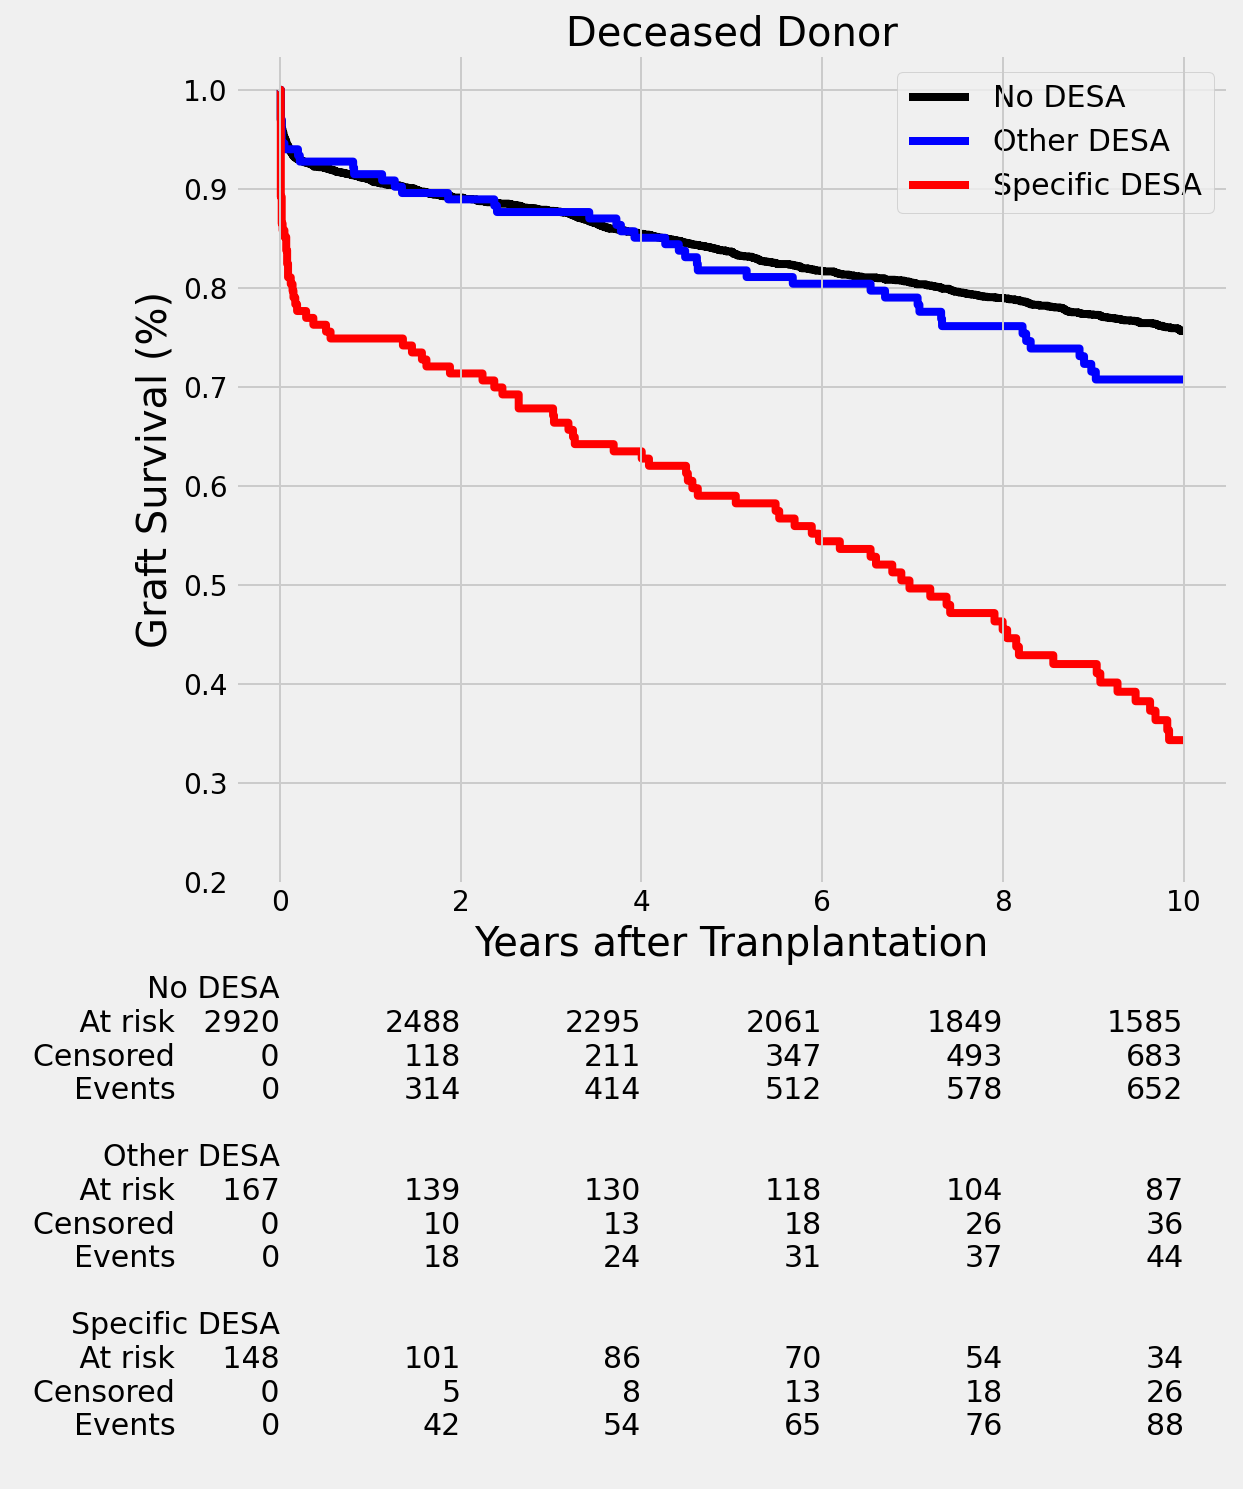

Top KM curve: 75.64, Middle KM curve:  70.74
10-Year Gap is:  41.33
1-Year Gap is:  16.60


In [5]:
# Not relevant 199V, 152HA, 31I, 65GK, 151AHA, 37FL, 98KN, 107W, 163LG, 163R, 57V[DR], 95V, 70QT, 70QA, 71ATD, 163RW, 57DE, 76ANT, 77NGT, 30H[DQ], 120N, 96Q, 97N, 13FE, 125G, 87Y, 
    # 173K, 66IF, 245V, 98E, 44RT, 152RA, 73AS, 55PPA, 71QS, 193PL, 76VS, 76VRN, 57V[DQ], 87F, 116I, 37YV[DQ], 125SQ, 73TVS, 80I, 30C, 267QE, 37F, 73AN, 152A, 37L, 70QRA, 177DT, 180E
    # 97S, 62LQ, 28D, 147L, 130Q, 73G, 73GQ, 104AK, 26L[DR]

# irrelevant = { '199V', '152HA', '31I', '65GK', '151AHA', '37FL', '98KN', '107W', '163LG', '163R', '57V[DR]', '95V', '70QT', '70QA', '71ATD', '163RW', '57DE', '76ANT', '77NGT',
#               '30H[DQ]', '120N', '96Q', '97N', '13FE', '125G', '87Y', '173K', '66IF', '245V', '98E', '44RT', '152RA', '73AS', '55PPA', '71QS', '193PL', '76VS', '76VRN', '57V[DQ]',
#               '87F', '116I', '37YV[DQ]', '125SQ', '73TVS', '80I', '30C', '267QE', '37F', '73AN', '152A', '37L', '70QRA', '177DT', '180E', '97S', '62LQ', '28D', '147L', '130Q', 
#               '73G', '73GQ', '104AK', '26L[DR]'}
    
# Maybe relevant: 55PP, 133RS, 185I, 144KR, 166ES, 162GLS, 66KH, 66KA, 55R, 96QN, 70GT, 70QA, 96Y, 98Q, 9T, 182N, 44KM, 51R, 67VG, 74S, 13SE, 77N[DR], 70QQ, 52PQ, 37YA, 77T[DQ]
    # 82LR, 56L, 80TA, 86A, 71KA, 114R, 166DG, 97I, 76EN, 97M, 181M, 76ESN, 71TTS, 37YV[DR], 67VT, 74EL, 16Y, 52LL, 41T, 81ALR, 76ESI, 30G[B], 38L, 71K, 70QK, 66IC, 96H, 152RR, 151AHE
    # 184A, 71SA, 47F, 70RE, 70R, 74E, 66EV, 25Q, 98ES, 17S, 80K, 253Q, 9H, 149AH, 67LQ, 71E, 70Q
    
# Relevant 45EV, 48Q, 151AHV, 156QA, 55PPD, 163RG, 151AHV, 127K, 161D, 96EV, 28H, 76ED, 96HK, 11STS, 149H, 108T, 45GV, 37S, 142M, 71A, 76ET, 80TLR, 56R, 30D, 150AAH, 70DA, 31FH, 70DRA, 
    # 45KE, 76VDT, 71TD, 62QE, 4Q, 62GRN, 74L, 30G[DR], 73ID, 67F, 66NH, 66NM, 74Y, 140TV, 46VY, 62EE, 158T, 150AH, 193AV, 30H[DR], 97V, 94I, 70DR, 6C, 65QIA, 207S, 105S, 32H
    
# Early Relevant: 9F[DQ], 45EV, 76ET, 80TLR, 245AS
# Late Relevant: 62GE, 96EV, 70QT, 57DE, 44KM, 120N, 13FE, 80TA, 71KA, 114R, 166DG, 181M, 74L, 66NM, 66IC, 151AHE, 30H[DR], 70RE, 74E, 31FY, 66EV

# Ourgalaxy teamn {'76ED', '45EV', '96EV', '149H', '96HK'} , 11STS, 108T, 45GV, 37S, 142M, 71A, 80TLR, 56R, 30D, 150AAH, 70DA, 31FH, 70DRA, 45KE, 76VDT, 71TD, 62QE, 4Q, 44RMA, 62GRN, 
# 74L, 30G[DR], 73ID, 67F, 66NH, 74Y, 74A, 140TV, 46VY, 62EE, 158T, 150AH, 245AS, 193AV, 144QL, 97V, 94I, 31FY, 6C, 65QIA, 207S, 105S, 32H

# '6C', '207S', '30G[DR]', '31FY', '32H', '44RMA', '45EV', '45GV', '45KE', '46VY', '94I', '96EV', '97V', '96HK', '11STS', '108T', '105S', '37S', '71A', 
#                              '80TLR', '56R', '30D', '150AAH', '31FH', '70DA', '70DRA','71TD', '74A', '74L', '74Y', '76VDT', '76ED',  '73ID', '62QE', '62EE', '62GRN', 
#                              '65QIA', '66NH', '67F', '4Q', '140TV', '142M', '144QL', '149H', '150AH', '158T', '158T', '193AV', '245AS'
# ALl relevant

class_I = { '44RMA', '45KE', '56R', '62EE', '62GRN', '62QE', '65QIA', '66NH', '71TD', '73ID', '74Y', '76ED', '76VDT', '80TLR', '94I', '97V', 
           '105S', '144QL', '150AAH', '150AH', '158T', '193AV', '207S', '245AS' }
class_II_dr = {'4Q', '6C', '30D', '30G[DR]', '31FY', '31FH', '32H', '37S', '67F', '70DA', '70DRA', '71A', '74A', '74L', '96EV', '96HK', '108T', '140TV', '142M', '149H'}
class_II_dq = {'45GV','45EV', '46VY'}

# High, Intermediate Ellipro 
high_int_ellipro_desa = {'32H', '67F', '70DRA', '65QIA', '6C', '73ID', '80TLR', '56R', '30D', '150AAH', '31FY', '46VY', '11STS', 
 '71A', '150AH', '96EV', '108T', '45GV', '31FH', '4Q', '37S', '105S', '140TV', '144QL', '71TD', '70DA', 
 '30G[DR]', '76VDT', '76ED', '74L', '245AS', '74A', '44RMA', '96HK', '45KE', '142M', '62QE', '62GRN', 
 '158T', '193AV', '62EE', '45EV'}
high_int_low_ellipro_desa = {'32H', '67F', '74Y', '70DRA', '6C', '65QIA', '73ID', '80TLR', '56R', '30D', '150AAH', '31FY', '46VY', '66NH', 
 '11STS', '71A', '150AH', '96EV', '108T', '45GV', '31FH', '4Q', '37S', '105S', '140TV', '144QL', '94I', '71TD', 
 '70DA', '30G[DR]', '76VDT', '76ED', '74L', '245AS', '74A', 
 '44RMA', '96HK', '45KE', '142M', '62QE', '62GRN', '158T', '193AV', '207S', '62EE', '45EV'}
late_relevant = {'62GE', '70QT', '57DE', '44KM', '120N', '13FE', '80TA', '71KA', '114R', '166DG', '181M', '66NM', 
                 '66IC', '151AHE', '30H[DR]', '70RE', '74E', '66EV', '144KR', '70QA', '16Y', '149AH'}
early_relevant = {'55R', '185I', '66KH', '66KA', '70GT', '76ET' '98Q', '67VG', '13SE', '37YA', '77T[DQ]', '76ESN', '71TTS', '51R', '9F[DQ]'}
early_irrelevant = {'76ANT', '77NGT', '13FE', '87Y', '76VS', '76VRN', '114R', '151AHE', '184A', '70RE', '70R', '74E', '98ES', '17S', '80K', '149AH'}

kmfs = kaplan_meier_curves(df, desa_spec= class_I | class_II_dr | class_II_dq)
plot_kaplan_meier_curve(kmfs)

# (class_I | class_II_dr | class_II_dq ) & early_relevant


# early_irrelevant & late_relevant
# plot_kaplan_meier_curve(df, desa_spec={'52RR'})

# Inverse Probability Weight

As implied by its name, inverse probability weighting literally refers to weighting the outcome measures by the inverse of the probability of the individual with a given set of covariates being assigned to their treatment (note that this doesn’t depend on whether or not the individual was in fact assigned to treatment). This quantity is known as the propensity score and is denoted by

$$p(x)=P(T=1|X=x)$$

In our case we have to change the treatment group to transplants having DSA/DESA group. Inverse probability weighting literally refers to weighting the outcome measures by the inverse of the probability of the Transplants with a given set of covariates being assigned to the having DSA group (note that this doesn’t depend on whether or not the Transplant actually has DSA/DESA). This quantity is known as the propensity score and is denoted by

$$p(x)=P(Tx\, \in DSA/DESA|X=x)$$


In [87]:
from src.constants import *
df = create_treatment_grups(df, RELEVANT_DESA_BAD)

confounders = [
    'RecipientAge_NOTR', 'RecipientAge_NOTR*RecipientAge_NOTR', 
    'DonorAge_NOTR', 'DonorAge_NOTR*DonorAge_NOTR', 'IL2rMoAb'
]
treatments = ['No_DESA', 'Other_DESA', 'Specific_DESA']
find_ipw(df, confounders, treatments)


[[0.91938276 0.90648324 0.9085059  ... 0.91397611 0.89480434 0.89630124]
 [0.97375169 0.9664239  0.96877802 ... 0.96523913 0.95000161 0.95014542]
 [0.02624831 0.0335761  0.03122198 ... 0.03476087 0.04999839 0.04985458]]
sum propensity score [1.91938276 1.90648324 1.9085059  ... 1.91397611 1.89480434 1.89630124]


0       4.058808
1       4.075884
2       4.070722
3       4.081915
4       4.073608
          ...   
4685    4.107652
4686    4.115653
4687    4.077024
4688    4.112090
4689    4.111497
Length: 4690, dtype: float64

In [6]:

variables = ['RecipientAge_NOTR', 'DonorAge_NOTR']

df

,TransplantID,DESA_Status,EpvsHLA_Donor,#DESA,DESA,RecipientAge_NOTR,DonorAge_NOTR,TypeOfDonor_NOTR,FailureCode10Y_R,GraftSurvival10Y_R,IL2rMoAb
0,4036,No DESA,{},0,{},54,44,Deceased,0,10.000000,1
1,2809,No DESA,{},0,{},32,54,Deceased,0,10.000000,1
2,862,No DESA,{},0,{},27,44,Deceased,1,6.956164,1
3,3549,No DESA,{},0,{},40,23,Deceased,0,4.509589,0
4,12,No DESA,{},0,{},38,55,Deceased,1,0.010959,1
...,...,...,...,...,...,...,...,...,...,...,...
4685,994,No MFI,{},0,{},43,51,Deceased,0,10.000000,0
4686,995,No DESA,{},0,{},37,54,Deceased,0,10.000000,0
4687,996,No MFI,{},0,{},46,21,Deceased,0,10.000000,0
4688,997,No MFI,{},0,{},23,42,Deceased,0,10.000000,0


In [95]:
formula

['No DESA ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTRIL2rMoAb',
 'Other DESA ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTRIL2rMoAb',
 'Specific DESA ~ RecipientAge_NOTR + RecipientAge_NOTR*RecipientAge_NOTR + DonorAge_NOTR + DonorAge_NOTR*DonorAge_NOTRIL2rMoAb']